In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense
physical_devices = tf.config.list_physical_devices('GPU')
print(f'Tensorflow found {len(physical_devices)} GPU.')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow found 1 GPU.


In [2]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

In [17]:
train_df = pd.read_csv('rsc/train.csv', keep_default_na=False)
test_df = pd.read_csv('rsc/test.csv', keep_default_na=False)

In [18]:
df= pd.concat([train_df, test_df]).reset_index(drop=True)

## Need to Clean data.

In [19]:
str_columns = df.dtypes[df.dtypes == object].index

In [20]:
def label_columns(df, cols, label):
    for col in cols:
        df[col] = df[col].map(label)

In [21]:
def label_dataset(df):
    cols_to_label = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    label = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2,'Po':1,'NA':0}
    label_columns(df, cols_to_label, label)

    cols_to_label = ['BsmtExposure']
    label = {'Gd':4, 'Av':3, 'Mn':2,'No':1,'NA':0}
    label_columns(df, cols_to_label, label)

    cols_to_label = ['BsmtFinType1', 'BsmtFinType2']
    label = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1, 'NA':0}
    label_columns(df, cols_to_label, label)

    cols_to_label = ['Functional'] 
    label = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4,'Maj1':3,'Maj2':2, 'Sev':1, 'Sal':0}
    label_columns(df, cols_to_label, label)

    cols_to_label = ['GarageFinish']
    label = {'Fin':3, 'RFn':2,'Unf':1,'NA':0}
    label_columns(df, cols_to_label, label)

    cols_to_label = ['PavedDrive', 'CentralAir']
    label = {'Y':2,'P':1,'N':0}
    label_columns(df, cols_to_label, label)

    cols_to_label = ['Fence']
    label = {'GdPrv':4, 'MnPrv':3, 'GdWo':2,'MnWw':1,'NA':0}
    label_columns(df, cols_to_label, label)

In [22]:
label_dataset(df)

In [23]:
to_one_hot_cols=[
    'MSZoning','Alley', 'LotShape','LandContour','LotConfig',
    'LandSlope','Neighborhood','Condition1','BldgType',
    'HouseStyle','RoofStyle','Exterior1st','MasVnrType',
    'Foundation','Electrical','GarageType','MiscFeature','SaleCondition']

In [24]:
df_onehot = pd.get_dummies(df, columns=to_one_hot_cols, drop_first=True, prefix='', prefix_sep='')[df.dtypes[df.dtypes != object].index]

In [40]:
train_dataset = df_onehot[:len(train_df)].drop(columns=['Id', 'SalePrice'])
test_dataset = df_onehot[len(train_df):].drop(columns=['Id', 'SalePrice'])
target = df_onehot[:len(train_df)]['SalePrice']

## Data Processing Complete!

In [30]:
dnn_norm = Normalization(input_shape=(train_dataset.shape[1],))
dnn_norm.adapt(train_dataset.to_numpy())

In [31]:
dnn_model = tf.keras.models.Sequential([
    dnn_norm,
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
dnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='MSE')

In [33]:
history = dnn_model.fit(train_dataset, target,
             validation_split=0.2,
             epochs=100,
            verbose=False
             )

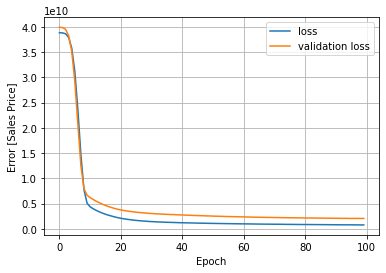

In [34]:
training_hist = pd.DataFrame.from_dict(history.history, orient='columns')
training_hist.index.name = 'epoch'
plot_training_hist(training_hist)

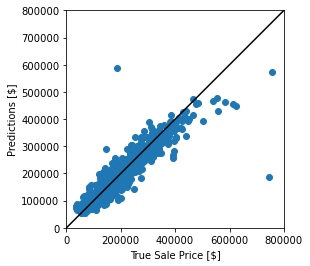

In [35]:
train_predictions = dnn_model.predict(train_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(target, train_predictions)
plt.xlabel('True Sale Price [$]')
plt.ylabel('Predictions [$]')
lims = [0, 800_000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='k')

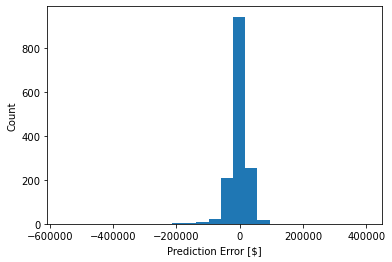

In [36]:
error = train_predictions - target
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [$]')
_ = plt.ylabel('Count')

In [41]:
test_predictions = dnn_model.predict(test_dataset).flatten()

In [42]:
test_dataset

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold
1460,20,11622,5,6,1961,1961,3,3,3,3,1,3,2,3,2,896,0,0,896,1,0,2,1,3,5,7.0,0,0,1,3,3,2,140,0,0,0,120,0,0,3,0,6,2010
1461,20,14267,6,6,1958,1958,3,3,3,3,1,5,1,3,2,1329,0,0,1329,1,1,3,1,4,6,7.0,0,0,1,3,3,2,393,36,0,0,0,0,0,0,12500,6,2010
1462,60,13830,5,5,1997,1998,3,3,4,3,1,6,1,4,2,928,701,0,1629,2,1,3,1,3,6,7.0,1,3,3,3,3,2,212,34,0,0,0,0,0,3,0,3,2010
1463,60,9978,6,6,1998,1998,3,3,3,3,1,6,1,5,2,926,678,0,1604,2,1,3,1,4,7,7.0,1,4,3,3,3,2,360,36,0,0,0,0,0,0,0,6,2010
1464,120,5005,8,5,1992,1992,4,3,4,3,1,5,1,5,2,1280,0,0,1280,2,0,2,1,4,5,7.0,0,0,2,3,3,2,0,82,0,0,144,0,0,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,1936,4,7,1970,1970,3,3,3,3,1,1,1,4,2,546,546,0,1092,1,1,3,1,3,5,7.0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,6,2006
2915,160,1894,4,5,1970,1970,3,3,3,3,1,3,1,3,2,546,546,0,1092,1,1,3,1,3,6,7.0,0,0,1,3,3,2,0,24,0,0,0,0,0,0,0,4,2006
2916,20,20000,5,7,1960,1996,3,3,3,3,1,5,1,5,2,1224,0,0,1224,1,0,4,1,3,7,7.0,1,3,1,3,3,2,474,0,0,0,0,0,0,0,0,9,2006
2917,85,10441,5,5,1992,1992,3,3,4,3,3,6,1,3,2,970,0,0,970,1,0,3,1,3,6,7.0,0,0,0,0,0,2,80,32,0,0,0,0,0,3,700,7,2006


In [49]:
submission = pd.DataFrame(test_predictions, index=test_dataset.index+1, columns=['SalePrice'])
submission.index.name = 'Id'
submission

,SalePrice
Id,
1461,115837.000000
1462,159564.687500
1463,169579.937500
1464,188821.484375
1465,189328.000000
...,...
2915,108902.195312
2916,114685.554688
2917,165248.500000


In [50]:
submission.to_csv('rsc/my_submission.csv')

# LOOL. 
Tests score: 0.21365